<a href="https://colab.research.google.com/github/TatianaO8/AI/blob/master/HW4_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 Problem 3 (2)

You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

## Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 17:41:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   316MB/s    in 0.2s    

2020-04-20 17:41:55 (316 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import Xception

conv_base = Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(150, 150, 3))

In [0]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 34,100,777
Trainable params: 13,239,297
Non-trainable params: 20,861,480
_________________________________

## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 21s 211ms/step - loss: 0.4819 - acc: 0.7600 - val_loss: 0.0880 - val_acc: 0.9370
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 0.3868 - acc: 0.8220 - val_loss: 0.1732 - val_acc: 0.9260
Epoch 3/100
100/100 [==============================] - 18s 176ms/step - loss: 0.3499 - acc: 0.8375 - val_loss: 0.2385 - val_acc: 0.9560
Epoch 4/100
100/100 [==============================] - 18s 178ms/step - loss: 0.3419 - acc: 0.8475 - val_loss: 0.0946 - val_acc: 0.9650
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 0.3373 - acc: 0.8490 - val_loss: 0.0012 - val_acc: 0.9690
Epoch 6/100
100/100 [==============================] - 18s 178ms/step - loss: 0.3205 - acc: 0.8510 - val_loss: 0.0178 - val_acc: 0.9680
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.3505 - acc: 0.8375 -

## Display curves of loss and accuracy during training

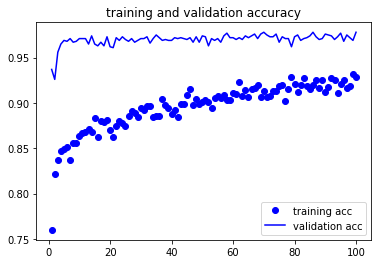

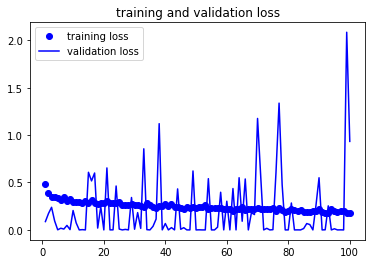

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv2d_4':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 202ms/step - loss: 0.1822 - acc: 0.9295 - val_loss: 0.0899 - val_acc: 0.9440
Epoch 2/100
100/100 [==============================] - 17s 170ms/step - loss: 0.1686 - acc: 0.9330 - val_loss: 0.0144 - val_acc: 0.9350
Epoch 3/100
100/100 [==============================] - 17s 171ms/step - loss: 0.1661 - acc: 0.9335 - val_loss: 0.1526 - val_acc: 0.9320
Epoch 4/100
100/100 [==============================] - 17s 170ms/step - loss: 0.1674 - acc: 0.9340 - val_loss: 0.3232 - val_acc: 0.9350
Epoch 5/100
100/100 [==============================] - 17s 172ms/step - loss: 0.1970 - acc: 0.9280 - val_loss: 0.0208 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 17s 169ms/step - loss: 0.1683 - acc: 0.9340 - val_loss: 0.5146 - val_acc: 0.9350
Epoch 7/100
100/100 [==============================] - 17s 169ms/step - loss: 0.1990 - acc: 0.9225 - val_loss: 0.1644 - val_acc: 0.9150
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

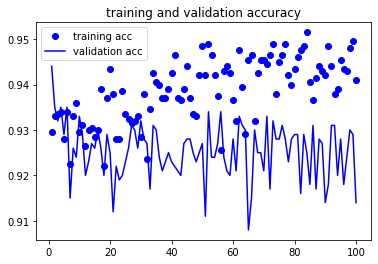

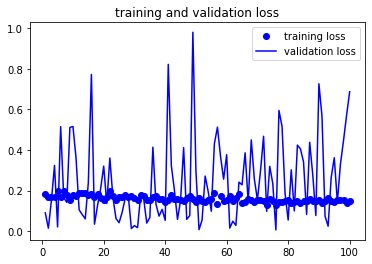

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.6862026453018188
Validation accuracy: 0.9139999747276306


#Conclusion

Compared to the first classifier, in this one I added two more dense layers. With this, after training, you can see that validation loss and validation accuracy is higher in this classifier. 

## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files
 b54
with open(model_fname, 'r') as f:
  files.download(model_fname)

MessageError: ignored